<a href="https://colab.research.google.com/github/CillaCole/Food-Sales-Predictions/blob/main/Copy_of_Food_Sales_Predictions_P5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Sales Predictions Part 5
- Priscilla E. Cole
September 16, 2022

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import set_config
set_config(display='diagram')

In [3]:
df = pd.read_csv('/content/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Make a Copy and Data Cleaning

In [5]:
ml_df = df.copy()

In [6]:
# Check for duplicates and address them appropriately
ml_df.duplicated().sum()

0

# Assign Features, Target and Create Pipelines

In [7]:
# define target (y) and features (X)
X = ml_df.drop(columns = ['Item_Outlet_Sales'])
y = ml_df['Item_Outlet_Sales']

In [8]:
# perform the split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [9]:
# column selectors
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

In [10]:
# SimpleImputers
mean_imputer = SimpleImputer(strategy = 'mean')
freq_imputer = SimpleImputer(strategy = 'most_frequent')
# Sclaing numeric columns
scaler = StandardScaler()

In [11]:
# OneHotEncoder for categorical data
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

In [12]:
# instantiate pipeline for numeric columns
num_pipe = make_pipeline(mean_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [13]:
# instantiate pipeline for categorical columns
cat_pipe = make_pipeline(freq_imputer, ohe)
cat_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [14]:
# instantiate column transformer and create tuples for column transformers
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

# column transformer
preprocessed = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
preprocessed 

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd65d2d4850>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd670645650>)])

In [15]:
# fit the pipeline on the train data
preprocessed.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd65d2d4850>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd670645650>)])

In [16]:
# transform the train and test data
X_train_processed = preprocessed.transform(X_train)
X_test_processed = preprocessed.transform(X_test)

In [17]:
# check missing values
ml_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [18]:
#select the numeric columns of each type
num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)
#check list info
print('numeric columns are', num_columns)
print('categorical columns are', cat_columns)

numeric columns are ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
categorical columns are ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


# Linear Regression Model Evaluation

In [45]:
# Build a linear regression model
reg = LinearRegression()
linreg_pipe = make_pipeline(preprocessed, reg)
linreg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd65d2d4850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd670645650>)])),
                ('linearregression', LinearRegression())])

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            6392 non-null   object 
 1   Item_Weight                5285 non-null   float64
 2   Item_Fat_Content           6392 non-null   object 
 3   Item_Visibility            6392 non-null   float64
 4   Item_Type                  6392 non-null   object 
 5   Item_MRP                   6392 non-null   float64
 6   Outlet_Identifier          6392 non-null   object 
 7   Outlet_Establishment_Year  6392 non-null   int64  
 8   Outlet_Size                4580 non-null   object 
 9   Outlet_Location_Type       6392 non-null   object 
 10  Outlet_Type                6392 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 599.2+ KB


In [47]:
# fit model pipeline on training data
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd65d2d4850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd670645650>)])),
                ('linearregression', LinearRegression())])

In [48]:
# Fit the model pipeline on the training data
linreg_pipe.fit(X_train, y_train)
# Make predictions using the training and testing data
training_predictions = linreg_pipe.predict(X_train)
test_predictions = linreg_pipe.predict(X_test)
training_predictions[:10]

array([3110., 3942., 2088.,  738., 2126.,  154., 1664., 3988., 3140.,
       1698.])

In [49]:
# Evaluate the performance of your model based on r^2
train_pred = linreg_pipe.predict(X_train)
test_pred = linreg_pipe.predict(X_test)

In [50]:
train_r2 = np.corrcoef(y_train, train_pred)[0][1]**2
test_r2 = np.corrcoef(y_test, test_pred)[0][1]**2
print(f'Model Training R2: {train_r2}')
print(f'Model Testing R2: {test_r2}')

Model Training R2: 0.6335079088876074
Model Testing R2: 0.0005789621859716164


In [51]:
# Evaluate the performance of your model based on RMSE
train_RMSE = np.sqrt(np.mean(np.abs(train_pred - y_train)**2))
test_RMSE = np.sqrt(np.mean(np.abs(test_pred - y_test)**2))
print(f'Model Training RMSE: {train_RMSE}')
print(f'Model Testing RMSE: {test_RMSE}')

Model Training RMSE: 1044.223304932342
Model Testing RMSE: 48869376284942.016


In [52]:

def evaluation_model(pipe=linreg_pipe,  model_name='', 
                     x_train='X_train', x_test='X_test'):
  # Train data
  mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),3)
  mse = round(mean_squared_error(y_train, pipe.predict(x_train)),3)
  rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),3)
  r2 = round(r2_score(y_train, pipe.predict(x_train)),7)
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.4f}\n')
  # Test data
  mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),3)
  mse = round(mean_squared_error(y_test, pipe.predict(x_test)),3)
  rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),3)
  r2 = round(r2_score(y_test, pipe.predict(x_test)),7)
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.4f}\n')

In [53]:
# Display model performance metrics
evaluation_model(pipe=linreg_pipe, model_name='Linear Regression',
                 x_train=X_train, x_test=X_test)

Linear Regression Train Scores
MAE: 787.68 
MSE: 1,090,402.31 
RMSE: 1,044.22 
R2: 0.6316

Linear Regression Test Scores
MAE: 3,296,404,132,227.80 
MSE: 2,388,215,938,479,253,396,893,204,480.00 
RMSE: 48,869,376,284,942.02 
R2: -865616382213080612864.0000



# Decision Tree Model Evaluation

In [54]:
# Build a regression tree model
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree_pipe = make_pipeline(preprocessed, dec_tree)
dec_tree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd65d2d4850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd670645650>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [55]:
# fit the model on the training data to learn the relationship
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd65d2d4850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd670645650>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [56]:
# Compare the performance of your model based on r^2
train_preds = dec_tree_pipe.predict(X_train)
test_preds = dec_tree_pipe.predict(X_test)

In [57]:
# Evaluate the model performance
train_score = dec_tree_pipe.score(X_train, y_train)
test_score = dec_tree_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

1.0
0.22560314645107293


In [58]:
# time to tune the model
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [59]:
# to get depth
dec_tree.get_depth()

81

In [60]:
# list values to try for depths:
depths = range(1, 80) # this will make sure to try for values between 1 and 80
# list to store the score each value of the max_depth
train_r2 = []
test_r2 = []
for depth in depths:
  dec_tree = DecisionTreeRegressor (max_depth = depth,
                                    random_state = 42)
  dec_tree_pipe = make_pipeline (preprocessed, dec_tree)
  # fit the new pipeline
  dec_tree_pipe.fit(X_train, y_train)
  train_score = dec_tree_pipe.score(X_train, y_train)
  test_score = dec_tree_pipe.score(X_test, y_test)
  train_r2.append(train_score)
  test_r2.append(test_score)

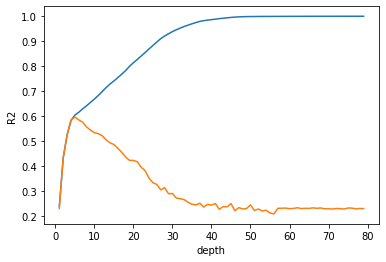

In [61]:
# for visualization on which depth achieve the highest r2 score
plt.plot(depths, train_r2)
plt.plot(depths, test_r2)
plt.xlabel('depth')
plt.ylabel('R2');

* The highest r2 score seems to be achieved at around a depth of 7.

In [64]:
# Create an instance of the model with the best depth determined from the visualization
dec_tree = DecisionTreeRegressor(max_depth=7, random_state = 42)
# Create a model pipeline
dec_tree_pipe = make_pipeline(preprocessed, dec_tree)
# Fit the model
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd65d2d4850>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd670645650>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=7, random_state=42))])

In [62]:
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics

def evaluation_model(pipe=dec_tree_pipe,  model_name='', 
                     x_train='X_train', x_test='X_test'):
  # Train data
  mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),3)
  mse = round(mean_squared_error(y_train, pipe.predict(x_train)),3)
  rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),3)
  r2 = round(r2_score(y_train, pipe.predict(x_train)),7)
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.4f}\n')
  # Test data
  mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),3)
  mse = round(mean_squared_error(y_test, pipe.predict(x_test)),3)
  rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),3)
  r2 = round(r2_score(y_test, pipe.predict(x_test)),7)
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.4f}\n')

In [65]:
# Display model performance metrics
evaluation_model(pipe=dec_tree_pipe, model_name='Decision Tree',
                 x_train=X_train, x_test=X_test)

Decision Tree Train Scores
MAE: 735.47 
MSE: 1,097,039.17 
RMSE: 1,047.40 
R2: 0.6293

Decision Tree Test Scores
MAE: 746.41 
MSE: 1,170,671.90 
RMSE: 1,081.98 
R2: 0.5757



- Upon reviewing the data, I would use the Decision Tree model to implement for the data set. The Decision Tree is the best option because the metrics (RMSE and R2) report a better fit by presenting low variance and low bias. 